<a href="https://colab.research.google.com/github/KimJuHan/pytorch_tutorial/blob/master/rnn_language_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
## 파일 한 개 업로드
# from google.colab import files
# uploaded = files.upload()

# 디렉토리 전체를 업로드 시킬 때는 구글 드라이브를 통해 마운트 시키는 것이 가장 효율적
# 하지만, 단점으로 코랩 연결이 끊어지면 메모리에서 데이터가 날라간다. 
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [2]:
cd gdrive/My\ Drive/data/names/

/content/gdrive/My Drive/data/names


In [0]:
# 현재 경로 확인
# gdrive/ 가 마운트된 것을 확인 할 수 있다.
ls -al

# gdrive 디렉토리로 이동
cd gdrive/My\ Drive/data/names/

In [4]:
from __future__ import print_function, unicode_literals, division
import glob
from io import open
import os
import string
import unicodedata

# 현재 디렉토리 내에 모든 파일 확인
glob.glob('*')

# 영어 + 특수문자
all_letters = string.ascii_letters + " .,;'"

# 유니코드 문자열을 ASCII로 변환, https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print(unicodeToAscii('Ślusàrski'))

# 각 언어의 이름 목록인 category_lines 사전 생성
category_lines = {}
all_categories = []

# 파일을 읽고 줄 단위로 분리
def readLines(filename):
  lines = open(filename, encoding='utf-8', mode='r').read().strip().split('\n')
  return [unicodeToAscii(line) for line in lines]

for filename in glob.glob('*'):
  category = os.path.splitext(filename)[0]
  all_categories.append(category)
  lines = readLines(filename)
  category_lines[category] = lines

print(all_categories)

Slusarski
['Arabic', 'Dutch', 'Czech', 'French', 'Chinese', 'English', 'Irish', 'German', 'Greek', 'Italian', 'Japanese', 'Russian', 'Portuguese', 'Polish', 'Scottish', 'Korean', 'Vietnamese', 'Spanish']


In [5]:
print(len(category_lines['Korean']))

94


In [6]:
import torch

# all_letters로 문자의 주소 찾기
def letterToIndex(letter):
  return all_letters.find(letter)

# < 1 x n_letters> Tensor 변환
def letterToTensor(letter):
  tensor = torch.zeros(1, len(all_letters))
  tensor[0][letterToIndex(letter)] = 1
  return tensor

# < line_length x 1 x n_letters >
def lineToTensor(line):
  tensor = torch.zeros(len(line), 1, len(all_letters))
  for idx, letter in enumerate(line):
    tensor[idx][0][letterToIndex(letter)] = 1
  return tensor

print(letterToTensor('J'))

print(lineToTensor('Jones').size())

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])
torch.Size([5, 1, 57])


In [0]:
import torch.nn as nn

class Model(nn.Module):
  def __init__(self, input_size, hidden_size, output_size):
    super(Model, self).__init__()
    
    self.hidden_size = hidden_size
    self.i2h = nn.Linear(input_size+hidden_size, hidden_size)
    self.i2o = nn.Linear(input_size+hidden_size, output_size)
    self.softmax = nn.LogSoftmax(dim=1)

  def forward(self, input, hidden):
    combined = torch.cat((input, hidden), 1)
    hidden = self.i2h(combined)
    output = self.i2o(combined)
    output = self.softmax(output)
    return output, hidden

  def initHidden(self):
    return torch.zeros(1, self.hidden_size)

In [0]:
n_hidden = 128
rnn = Model(len(all_letters), n_hidden, len(all_categories))

In [46]:
input = lineToTensor('Albert')
hidden = rnn.initHidden()

output, next_hidden = rnn(input[0], hidden)
print(output)

tensor([[-2.9118, -2.9918, -2.8357, -2.8866, -2.8071, -2.8571, -2.7948, -2.9410,
         -2.9591, -2.8617, -2.9326, -2.8154, -2.9722, -2.9655, -2.8596, -2.9428,
         -2.8706, -2.8533]], grad_fn=<LogSoftmaxBackward>)


In [62]:
def categoryFromOutput(output):
  top_n, top_i = output.topk(1)
  category_i = top_i[0].item()
  return all_categories[category_i], category_i

print(categoryFromOutput(output))

('Italian', 9)


In [48]:
print(output.max(dim=1)[0])
print(output.max(dim=1)[1])

tensor([-2.7948], grad_fn=<MaxBackward0>)
tensor([6])


In [49]:
import random

def randomChoice(l):
  return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
  category = randomChoice(all_categories)
  line = randomChoice(category_lines[category])
  category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
  line_tensor = lineToTensor(line)
  return category, line, category_tensor, line_tensor

for i in range(10):
  category, line, category_tensor, line_tensor = randomTrainingExample()
  print('category = ', category, '| line =', line)

category =  Russian | line = Hitarov
category =  Irish | line = Connell
category =  Russian | line = Dobriyan
category =  Irish | line = Roach
category =  Portuguese | line = Soares
category =  Greek | line = Avgerinos
category =  English | line = Elphick
category =  Vietnamese | line = Mach
category =  English | line = Carr
category =  Portuguese | line = Melo


In [0]:
# RNN의 마지막 계층이 nn.LogSoftmax이므로 손실 함수로 nn.NLLLoss가 적합하다
criterion = nn.NLLLoss()

lr = 0.005

def train(category_tensor, line_tensor):
  hidden = rnn.initHidden()

  rnn.zero_grad()

  # 글자 수만큼 rnn모델에 돌린다.
  for i in range(line_tensor.size()[0]):
    output, hidden = rnn(line_tensor[i], hidden)

  loss = criterion(output, category_tensor)
  loss.backward()

  for p in rnn.parameters():
    p.data.add_(-lr , p.grad.data)

  return output, loss.item()

In [64]:
import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1000

current_loss = 0
all_losses = []

def timeSince(since):
  now = time.time()
  s = now - since
  m = math.floor(s/60)
  s -= m*60
  return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
  category, line, category_tensor, line_tensor = randomTrainingExample()
  output, loss = train(category_tensor, line_tensor)
  current_loss += loss

  if iter % print_every == 0:
    guess, guess_i = categoryFromOutput(output)
    correct = 'O' if guess == category else 'X' 
    print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, 
                                            line, guess, correct))
  
  if iter % plot_every == 0:
    all_losses.append(current_loss / plot_every)
    current_loss = 0

5000 5% (0m 9s) 0.5826 Chu / Vietnamese O
10000 10% (0m 18s) 0.9697 Dounias / Portuguese X
15000 15% (0m 27s) 0.3427 Fashingbauer / German O
20000 20% (0m 36s) 0.0040 Takishida / Japanese O
25000 25% (0m 46s) 0.6769 Pavia / Spanish O
30000 30% (0m 55s) 1.2820 Tian / Vietnamese X
35000 35% (1m 4s) 0.4847 Reinder / Dutch O
40000 40% (1m 13s) 0.3055 Hoefler / German O
45000 45% (1m 22s) 0.2526 Middlesworth / Dutch O
50000 50% (1m 32s) 1.4954 Abascal / Czech X
55000 55% (1m 41s) 0.1396 Hyun  / Korean O
60000 60% (1m 50s) 1.5084 Severins / Dutch O
65000 65% (1m 59s) 0.2189 Tieu / Vietnamese O
70000 70% (2m 8s) 0.0083 Assaf / Arabic O
75000 75% (2m 17s) 0.9269 Loenko / Czech X
80000 80% (2m 26s) 1.5370 Gage / French O
85000 85% (2m 35s) 0.1753 Donovan / Irish O
90000 90% (2m 44s) 1.6799 Hizhny / Scottish X
95000 95% (2m 53s) 0.0648 Anselmi / Italian O
100000 100% (3m 2s) 0.7672 Jang / Chinese X


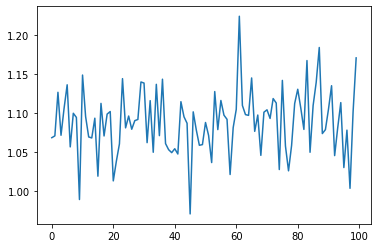

In [65]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

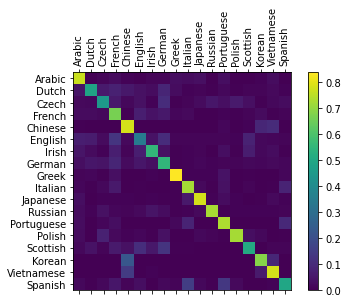

In [66]:
confusion = torch.zeros(len(all_categories), len(all_categories))
n_confusion = 10000

def evaluate(line_tensor):
  hidden = rnn.initHidden()

  for i in range(line_tensor.size()[0]):
    output, hidden = rnn(line_tensor[i], hidden)

  return output

for i in range(n_confusion):
  category, line, category_tensor, line_tensor = randomTrainingExample()
  output = evaluate(line_tensor)
  guess, guess_i = categoryFromOutput(output)
  category_i = all_categories.index(category)
  confusion[category_i][guess_i] += 1

for i in range(len(all_categories)):
  confusion[i] = confusion[i] / confusion[i].sum()

fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

plt.show()

In [67]:
def predict(input_line, n_predictions=3):
  print('\n> %s' % input_line)
  with torch.no_grad():
    output = evaluate(lineToTensor(input_line))

    topv, topi = output.topk(n_predictions, 1, True)
    predictions = []

    for i in range(n_predictions):
      value = topv[0][i].item()
      category_index = topi[0][i].item()
      print('(%.2f) %s' % (value, all_categories[category_index]))
      predictions.append([value, all_categories[category_index]])

predict('Dovesky')
predict('Jackson')
predict('Satoshi')


> Dovesky
(-0.74) Russian
(-1.13) Czech
(-2.17) English

> Jackson
(-0.43) Scottish
(-1.21) English
(-3.88) Russian

> Satoshi
(-0.74) Japanese
(-1.36) Arabic
(-1.65) Italian
